In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from scipy.stats import laplace, skewnorm
from tqdm import tqdm
import pandas as pd


plt.rcParams['figure.figsize'] = (12, 8)
sns.set(style='whitegrid', palette='husl')
plt.rcParams['font.size'] = 12

def generate_laplace_samples(n, beta=np.sqrt(0.5)):
    return laplace.rvs(loc=0, scale=beta, size=n)

def generate_skewnorm_samples(n, alpha=1):
    return skewnorm.rvs(alpha, size=n)

def build_knn_graph(samples, k=5):
    n = len(samples)
    G = nx.Graph()
    G.add_nodes_from(range(n))

    samples_2d = samples.reshape(-1, 1)
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(samples_2d)
    _, indices = nbrs.kneighbors(samples_2d)

    for i in range(n):
        for j in indices[i][1:]:
            G.add_edge(i, j)
    return G

def build_distance_graph(samples, d=0.5):
    n = len(samples)
    G = nx.Graph()
    G.add_nodes_from(range(n))

    for i in range(n):
        for j in range(i+1, n):
            if abs(samples[i] - samples[j]) <= d:
                G.add_edge(i, j)
    return G

def calculate_graph_stats(G):
    num_components = nx.number_connected_components(G)

    coloring = nx.greedy_color(G, strategy='largest_first')
    chromatic_number = max(coloring.values()) + 1

    return num_components, chromatic_number

def generate_dataset(n, graph_type, n_samples_per_class=1000):
    """Генерация набора данных с двумя классами и двумя признаками"""
    features = []
    labels = []

    # Генерация данных для H0 (Laplace)
    for _ in tqdm(range(n_samples_per_class), desc=f"Generating H0 (n={n})"):
        samples = generate_laplace_samples(n)

        if graph_type == 'knn':
            G = build_knn_graph(samples)
        else:
            G = build_distance_graph(samples)

        stats = calculate_graph_stats(G)
        features.append(stats)
        labels.append(0)

    # Генерация данных для H1 (SkewNormal)
    for _ in tqdm(range(n_samples_per_class), desc=f"Generating H1 (n={n})"):
        samples = generate_skewnorm_samples(n)

        if graph_type == 'knn':
            G = build_knn_graph(samples)
        else:
            G = build_distance_graph(samples)

        stats = calculate_graph_stats(G)
        features.append(stats)
        labels.append(1)

    return np.array(features), np.array(labels)

#1. Классификация с использованием обеих характеристик

Generating H1 (n=500): 100%|██████████| 1000/1000 [01:28<00:00, 11.27it/s]


     n graph_type  component_importance  chromatic_importance  \
0   25        knn              0.656496              0.343504   
1   25   distance              0.863363              0.136637   
2  100        knn              0.793064              0.206936   
3  100   distance              0.635432              0.364568   
4  500        knn              0.806819              0.193181   
5  500   distance              0.307321              0.692679   

   total_importance  
0               1.0  
1               1.0  
2               1.0  
3               1.0  
4               1.0  
5               1.0  


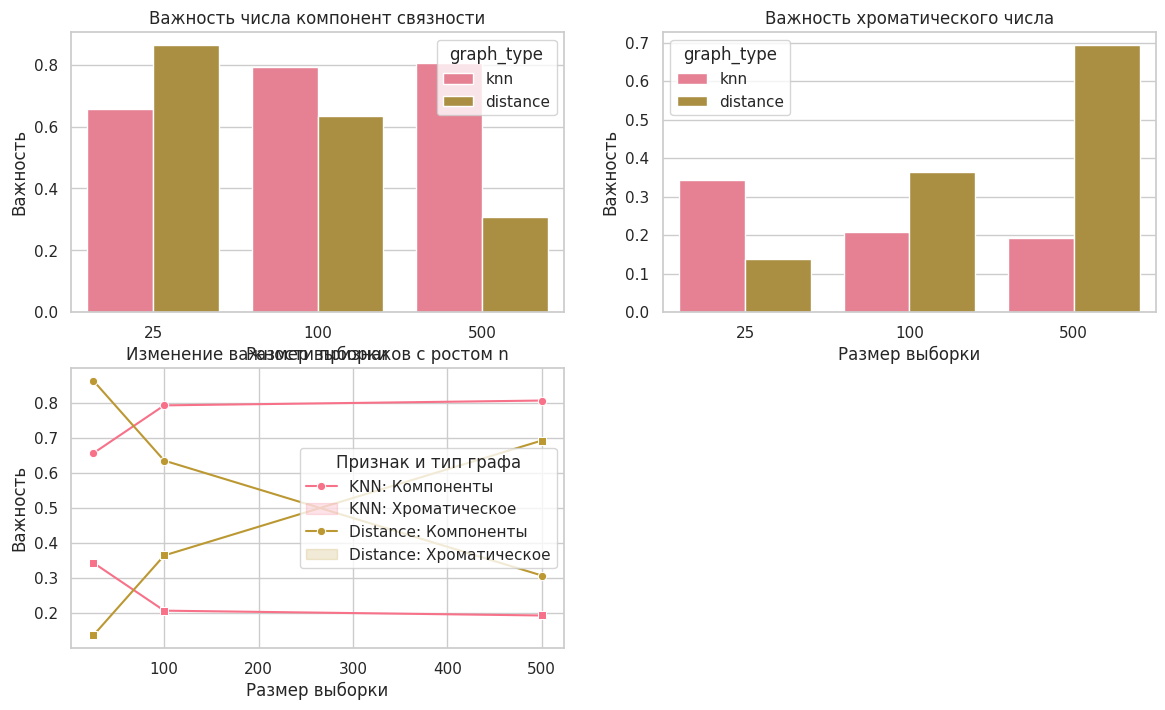

In [8]:
def analyze_feature_importance(n_values, graph_types):
    results = []

    for n in n_values:
        for graph_type in graph_types:
            # Генерация данных
            X, y = generate_dataset(n, graph_type, 1000)

            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X, y)


            importance = rf.feature_importances_

            results.append({
                'n': n,
                'graph_type': graph_type,
                'component_importance': importance[0],
                'chromatic_importance': importance[1],
                'total_importance': importance[0] + importance[1]
            })

    df = pd.DataFrame(results)


    plt.figure(figsize=(14, 8))

    plt.subplot(2, 2, 1)
    sns.barplot(x='n', y='component_importance', hue='graph_type', data=df)
    plt.title('Важность числа компонент связности')
    plt.ylabel('Важность')
    plt.xlabel('Размер выборки')


    plt.subplot(2, 2, 2)
    sns.barplot(x='n', y='chromatic_importance', hue='graph_type', data=df)
    plt.title('Важность хроматического числа')
    plt.ylabel('Важность')
    plt.xlabel('Размер выборки')

    plt.subplot(2, 2, 3)
    sns.lineplot(x='n', y='component_importance', hue='graph_type', data=df, marker='o')
    sns.lineplot(x='n', y='chromatic_importance', hue='graph_type', data=df, marker='s')
    plt.title('Изменение важности признаков с ростом n')
    plt.ylabel('Важность')
    plt.xlabel('Размер выборки')
    plt.legend(title='Признак и тип графа',
               labels=['KNN: Компоненты', 'KNN: Хроматическое',
                       'Distance: Компоненты', 'Distance: Хроматическое'])



    return df


n_values = [25, 100, 500]
graph_types = ['knn', 'distance']

importance_df = analyze_feature_importance(n_values, graph_types)
print(importance_df)

# Сравнение классификаторов

Generating H1 (n=500): 100%|██████████| 1000/1000 [01:28<00:00, 11.24it/s]


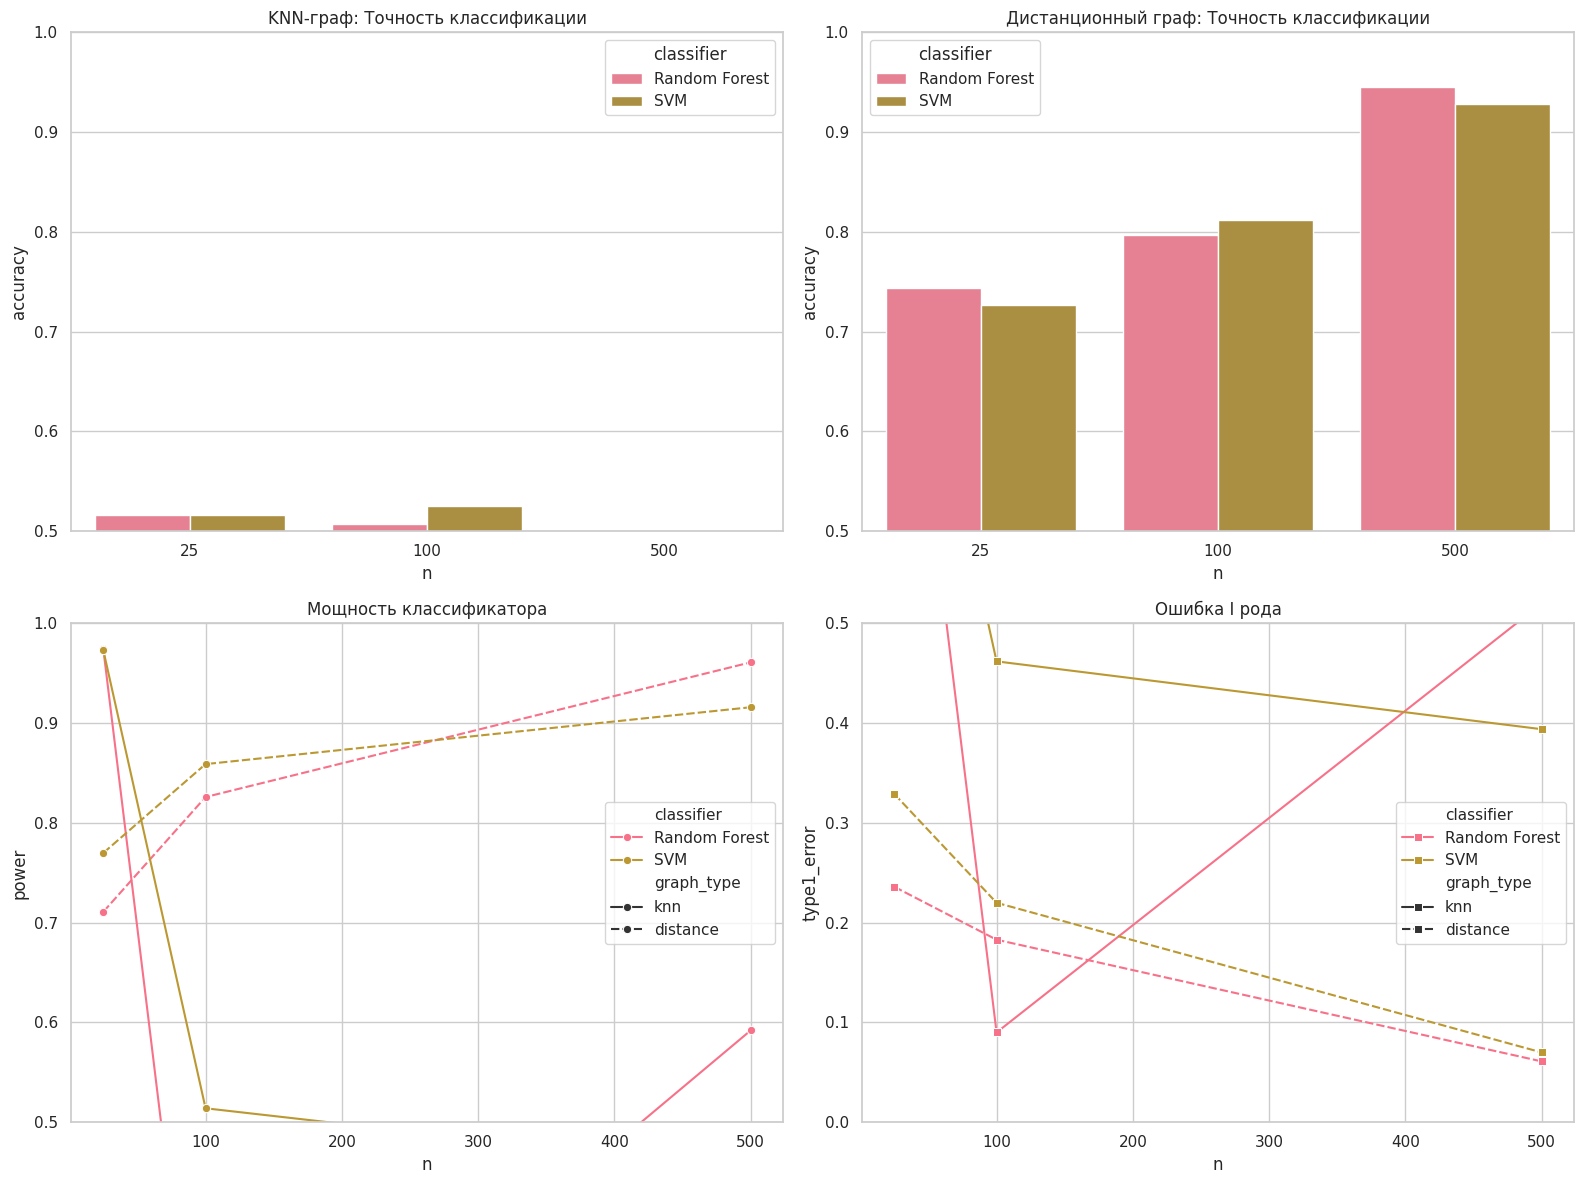

Generating H1 (n=100): 100%|██████████| 1000/1000 [00:03<00:00, 271.39it/s]


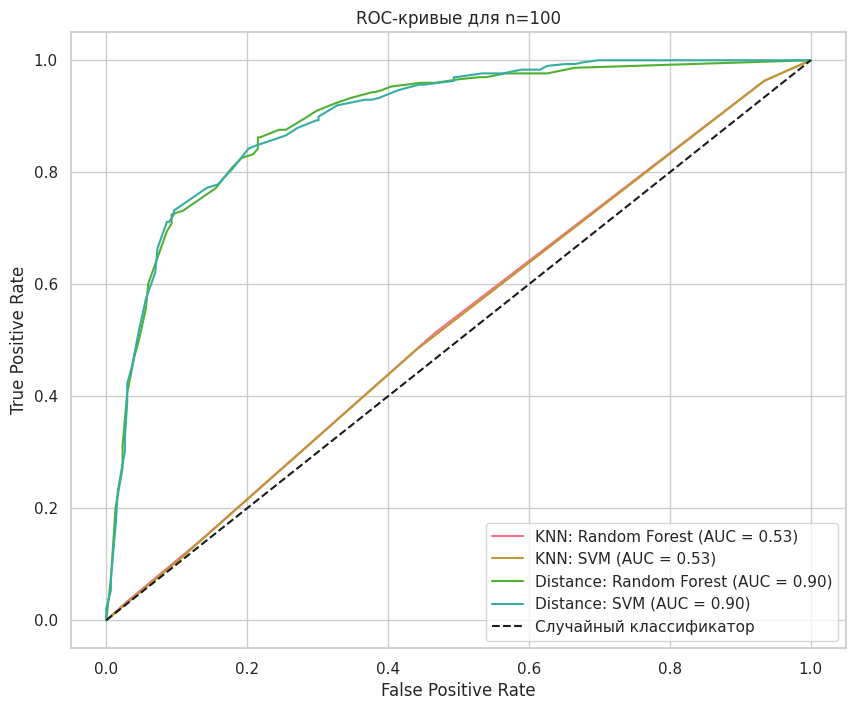

      n graph_type     classifier  accuracy  type1_error  power   roc_auc
0    25        knn  Random Forest  0.516667        0.927  0.974  0.537868
1    25        knn            SVM  0.516667        0.927  0.973  0.537868
2    25   distance  Random Forest  0.743333        0.236  0.711  0.789930
3    25   distance            SVM  0.726667        0.329  0.770  0.789930
4   100        knn  Random Forest  0.506667        0.090  0.134  0.524723
5   100        knn            SVM  0.525000        0.462  0.514  0.524723
6   100   distance  Random Forest  0.796667        0.183  0.826  0.889351
7   100   distance            SVM  0.811667        0.220  0.859  0.889351
8   500        knn  Random Forest  0.475000        0.520  0.592  0.468115
9   500        knn            SVM  0.465000        0.394  0.452  0.468115
10  500   distance  Random Forest  0.945000        0.061  0.961  0.979588
11  500   distance            SVM  0.928333        0.070  0.916  0.979588


In [12]:
def compare_classifiers(n_values, graph_types):
    results = []

    for n in n_values:
        for graph_type in graph_types:
            # Генерация данных
            X, y = generate_dataset(n, graph_type, 1000)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

            # Обучение моделей
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X_train, y_train)
            rf_pred = rf.predict(X_test)
            rf_acc = accuracy_score(y_test, rf_pred)

            svm = SVC(kernel='rbf', probability=True, random_state=42)
            svm.fit(X_train, y_train)
            svm_pred = svm.predict(X_test)
            svm_acc = accuracy_score(y_test, svm_pred)

            # Оценка ошибки I рода и мощности
            rf_type1_error = np.mean(rf.predict(X[y == 0]) != 0)
            rf_power = np.mean(rf.predict(X[y == 1]) == 1)

            svm_type1_error = np.mean(svm.predict(X[y == 0]) != 0)
            svm_power = np.mean(svm.predict(X[y == 1]) == 1)


            rf_probs = rf.predict_proba(X_test)[:, 1]
            fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
            roc_auc_rf = auc(fpr_rf, tpr_rf)


            results.append({
                'n': n,
                'graph_type': graph_type,
                'classifier': 'Random Forest',
                'accuracy': rf_acc,
                'type1_error': rf_type1_error,
                'power': rf_power,
                'roc_auc': roc_auc_rf
            })

            results.append({
                'n': n,
                'graph_type': graph_type,
                'classifier': 'SVM',
                'accuracy': svm_acc,
                'type1_error': svm_type1_error,
                'power': svm_power,
                'roc_auc': roc_auc_rf
            })


    df = pd.DataFrame(results)


    fig, axes = plt.subplots(2, 2, figsize=(16, 12))


    sns.barplot(x='n', y='accuracy', hue='classifier',
                data=df[df['graph_type'] == 'knn'], ax=axes[0, 0])
    axes[0, 0].set_title('KNN-граф: Точность классификации')
    axes[0, 0].set_ylim(0.5, 1.0)

    sns.barplot(x='n', y='accuracy', hue='classifier',
                data=df[df['graph_type'] == 'distance'], ax=axes[0, 1])
    axes[0, 1].set_title('Дистанционный граф: Точность классификации')
    axes[0, 1].set_ylim(0.5, 1.0)

    # Мощность и ошибка I рода
    sns.lineplot(x='n', y='power', hue='classifier', style='graph_type',
                 data=df, marker='o', ax=axes[1, 0])
    axes[1, 0].set_title('Мощность классификатора')
    axes[1, 0].set_ylim(0.5, 1.0)

    sns.lineplot(x='n', y='type1_error', hue='classifier', style='graph_type',
                 data=df, marker='s', ax=axes[1, 1])
    axes[1, 1].set_title('Ошибка I рода')
    axes[1, 1].set_ylim(0.0, 0.5)

    plt.tight_layout()
    plt.savefig('classifiers_comparison.png', dpi=300)
    plt.show()

    plt.figure(figsize=(10, 8))


    X_knn, y_knn = generate_dataset(100, 'knn', 1000)
    X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.3, random_state=42)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_probs = rf.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    plt.plot(fpr_rf, tpr_rf, label=f'KNN: Random Forest (AUC = {roc_auc_rf:.2f})')

    svm = SVC(kernel='rbf', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    svm_probs = svm.predict_proba(X_test)[:, 1]
    fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    plt.plot(fpr_svm, tpr_svm, label=f'KNN: SVM (AUC = {roc_auc_svm:.2f})')

    X_dist, y_dist = generate_dataset(100, 'distance', 1000)
    X_train, X_test, y_train, y_test = train_test_split(X_dist, y_dist, test_size=0.3, random_state=42)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_probs = rf.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    plt.plot(fpr_rf, tpr_rf, label=f'Distance: Random Forest (AUC = {roc_auc_rf:.2f})')

    svm = SVC(kernel='rbf', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    svm_probs = svm.predict_proba(X_test)[:, 1]
    fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    plt.plot(fpr_svm, tpr_svm, label=f'Distance: SVM (AUC = {roc_auc_svm:.2f})')


    plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривые для n=100')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig('roc_curves.png', dpi=300)
    plt.show()

    return df


n_values = [25, 100, 500]
graph_types = ['knn', 'distance']

classifiers_df = compare_classifiers(n_values, graph_types)
print(classifiers_df)

# Анализ дисперсии метрик качества

Generating H1 (n=500): 100%|██████████| 500/500 [00:46<00:00, 10.76it/s]


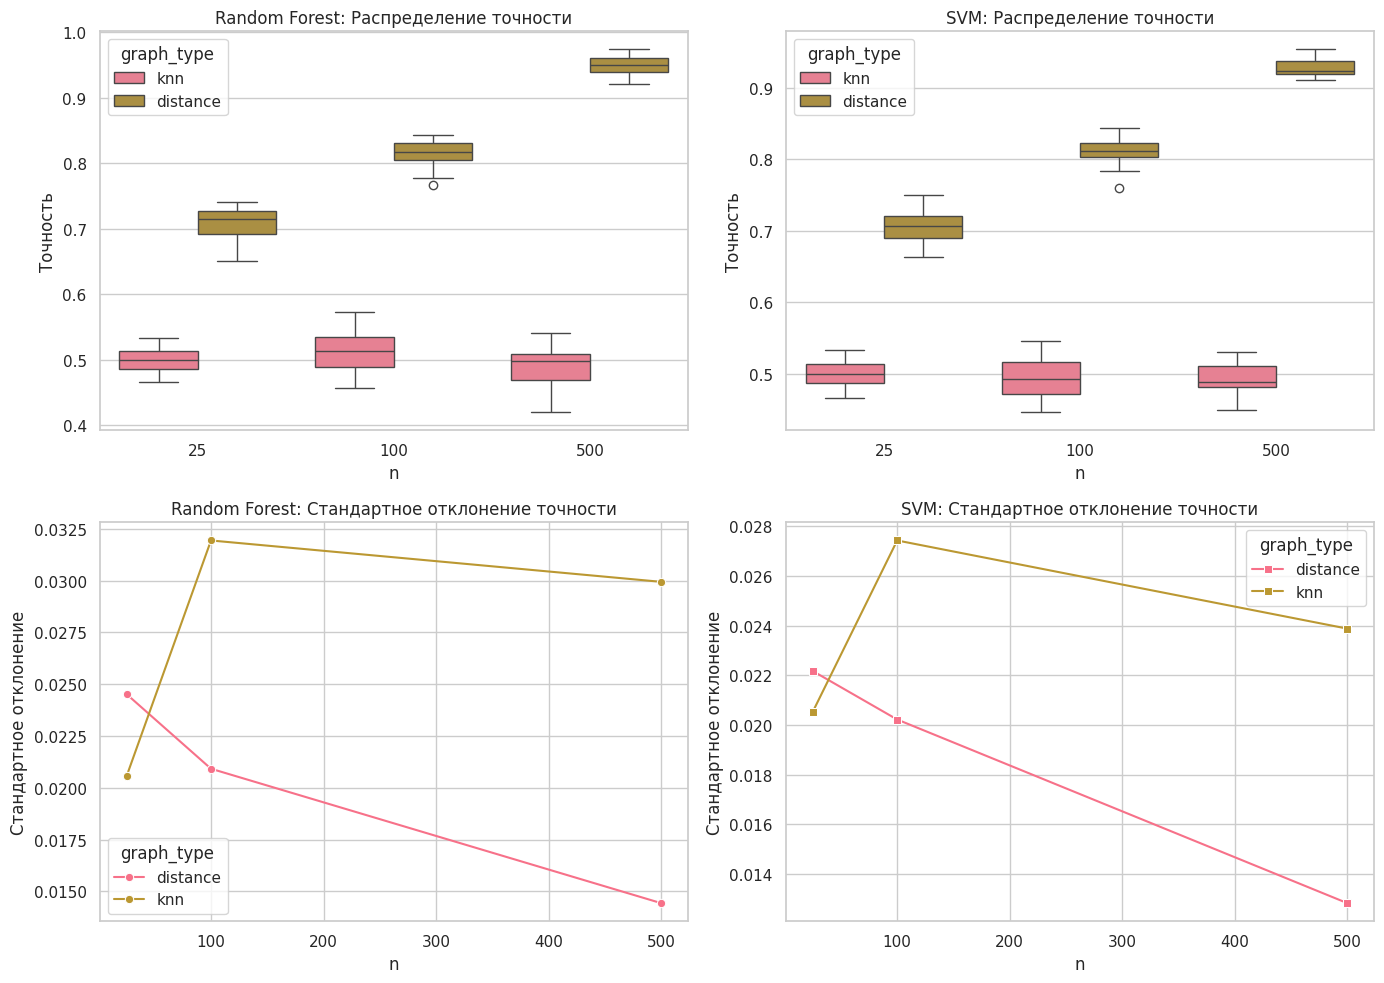

               rf_accuracy           svm_accuracy          
                      mean       std         mean       std
n   graph_type                                             
25  distance      0.707500  0.024516     0.704500  0.022171
    knn           0.498000  0.020559     0.498667  0.020531
100 distance      0.814333  0.020918     0.811833  0.020217
    knn           0.512500  0.031933     0.493500  0.027434
500 distance      0.949000  0.014433     0.928167  0.012818
    knn           0.488833  0.029937     0.492667  0.023881


In [13]:
def analyze_metric_variance(n_values, graph_types, n_iter=10):
    results = []

    for n in n_values:
        for graph_type in graph_types:
            for _ in range(n_iter):
                # Генерация данных
                X, y = generate_dataset(n, graph_type, 500)
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

                # Обучение моделей
                rf = RandomForestClassifier(n_estimators=100)
                rf.fit(X_train, y_train)
                rf_acc = accuracy_score(y_test, rf.predict(X_test))

                svm = SVC(kernel='rbf', probability=True)
                svm.fit(X_train, y_train)
                svm_acc = accuracy_score(y_test, svm.predict(X_test))

                # Сохранение результатов
                results.append({
                    'n': n,
                    'graph_type': graph_type,
                    'iteration': _,
                    'rf_accuracy': rf_acc,
                    'svm_accuracy': svm_acc
                })


    df = pd.DataFrame(results)

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    sns.boxplot(x='n', y='rf_accuracy', hue='graph_type', data=df)
    plt.title('Random Forest: Распределение точности')
    plt.ylabel('Точность')


    plt.subplot(2, 2, 2)
    sns.boxplot(x='n', y='svm_accuracy', hue='graph_type', data=df)
    plt.title('SVM: Распределение точности')
    plt.ylabel('Точность')


    plt.subplot(2, 2, 3)
    sns.lineplot(x='n', y='rf_accuracy', hue='graph_type',
                 data=df.groupby(['n', 'graph_type', 'iteration']).mean().reset_index(),
                 estimator='std', err_style=None, marker='o')
    plt.title('Random Forest: Стандартное отклонение точности')
    plt.ylabel('Стандартное отклонение')

    plt.subplot(2, 2, 4)
    sns.lineplot(x='n', y='svm_accuracy', hue='graph_type',
                 data=df.groupby(['n', 'graph_type', 'iteration']).mean().reset_index(),
                 estimator='std', err_style=None, marker='s')
    plt.title('SVM: Стандартное отклонение точности')
    plt.ylabel('Стандартное отклонение')

    plt.tight_layout()
    plt.savefig('metric_variance.png', dpi=300)
    plt.show()

    return df


n_values = [25, 100, 500]
graph_types = ['knn', 'distance']
variance_df = analyze_metric_variance(n_values, graph_types, n_iter=20)
print(variance_df.groupby(['n', 'graph_type']).agg({'rf_accuracy': ['mean', 'std'],
                                                  'svm_accuracy': ['mean', 'std']}))